## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we conducted an A/B test run by a fictional e-commerce website. Our goal was to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [6]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset.

In [7]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [8]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [9]:
# all users
df.converted.sum() / df.user_id.count()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [10]:
df.query('group == "treatment" & landing_page == "old_page"').timestamp.count()

1965

In [11]:
df.query('group == "control" & landing_page == "new_page"').timestamp.count()

1928

In [12]:
df.query('group == "treatment" & landing_page == "old_page"').timestamp.count() + df.query('group == "control" & landing_page == "new_page"').timestamp.count()

3893

f. Do any of the rows have missing values?

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No, there are no missing values!

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Therefore, the rows where the **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page** will be **removed**

a. Store your new dataframe in **df2**.

In [14]:
df2 = df.query('group == "treatment" & landing_page == "new_page" | group == "control" & landing_page == "old_page"')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** for a first clean up of the data

a. Unique **user_id**s in **df2**?

In [16]:
df2.user_id.nunique()

290584

In [17]:
df2.user_id.count()

290585

b. Repeated **user_id** in **df2**?

In [18]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. Row information for the repeated **user_id**? 

In [19]:
df2[df2.user_id.duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [20]:
df2.user_id.drop_duplicates(inplace = True)
df2.user_id.count()

/anaconda3/lib/python3.6/site-packages/pandas/core/base.py:1128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return self._update_inplace(result)


290584

In [21]:
df2.user_id.count() == df2.user_id.nunique()

True

`4.` Use **df2** to get basic statistics of the dataset

a. Probability of an individual converting regardless of the page they receive

In [22]:
df2.converted.mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
df2.query('group == "treatment"').converted.mean()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [25]:
df2.query('landing_page == "new_page"').user_id.count() / df2.shape[0]

0.5000636646764286

e. First indication of the results based on the initial statistics

Assumption is that there is no improvement due to the new page. The convertion ratio of the new page even decreased slightly compared to the old page. Statistical significance of the finding has to be proved in the A/B and Hypothesis test.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5% the **$p_{old}$** and **$p_{new}$** are as follows


$$H_0: p_{old} - p_{new} \geq 0$$


$$H_1: p_{old} - p_{new}  < 0$$

$p_{} $ is the mean convertion rate of the old and the new website

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. **Convert rate** for $p_{new}$ under the null

In [26]:
# assume they are equal to the converted rate in ab_data.csv regardless of the page
p_new = df2.converted.mean()
p_new

0.11959667567149027

b. **Convert rate** for $p_{old}$ under the null

In [27]:
# assume they are equal to the converted rate in ab_data.csv regardless of the page
p_old = df2.converted.mean()
p_old

0.11959667567149027

c. $n_{new}$

In [28]:
n_new = df2.query('group == "treatment"').user_id.nunique()
n_new

145310

d. $n_{old}$

In [29]:
n_old = df2.query('group == "control"').user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [44]:
new_converted = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted = np.random.binomial(n_old, p_old,  10000)/n_old
diffs = new_converted - old_converted

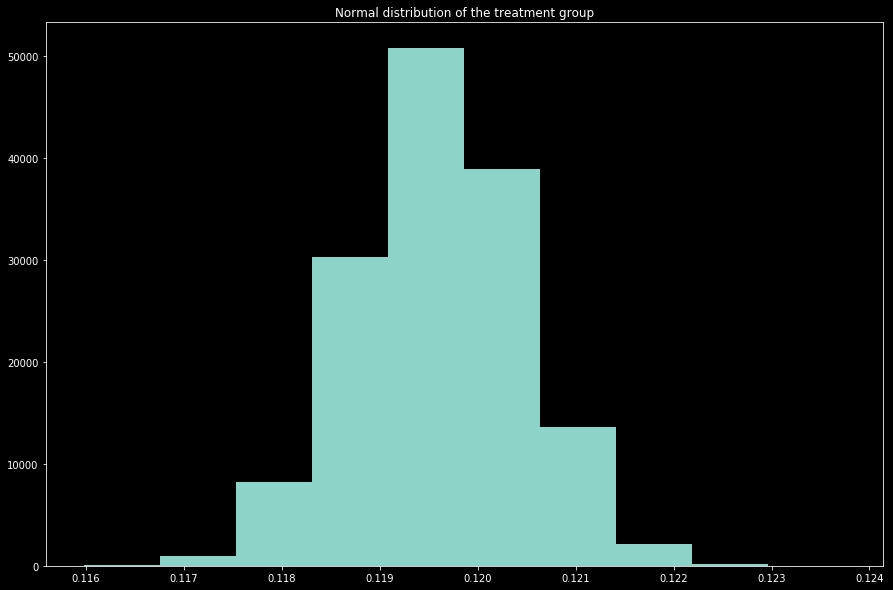

In [45]:
# Simulate the null
new_page_converted = np.random.normal(loc = p_new, scale = np.std(treatment_means), size = n_new)

# Plotting
plt.style.use(['dark_background'])
plt.figure(figsize=(15,10))
plt.title('Normal distribution of the treatment group')

plt.hist(new_page_converted);

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

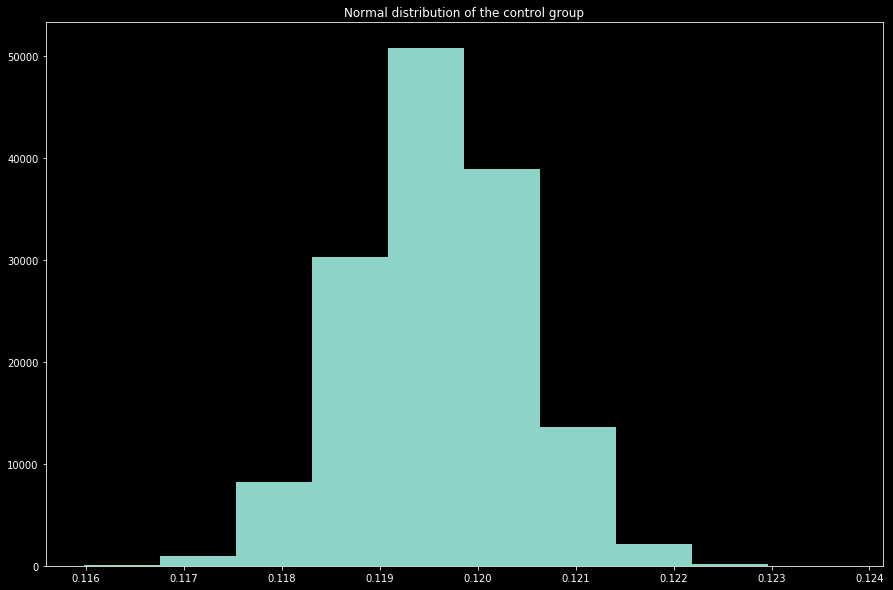

In [46]:
# Simulate the null
old_page_converted = np.random.normal(loc = p_old, scale = np.std(control_means), size = n_old)

# Plotting
plt.style.use(['dark_background'])
plt.figure(figsize=(15,10))
plt.title('Normal distribution of the control group')

plt.hist(new_page_converted);

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [47]:
#p_new - p_old
old_page_converted.mean() - new_page_converted.mean()

-1.5029060614069056e-07

The difference is almost 0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [48]:
# Simulate the null
p_diffs = np.random.normal(0, np.std(diffs), df2.shape[0])

i. Plot a histogram of the **p_diffs**

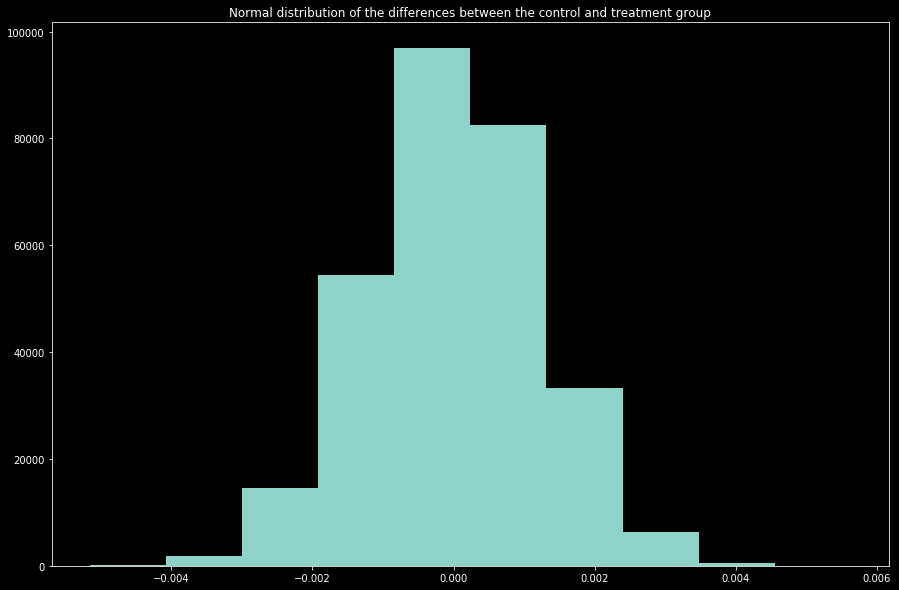

In [49]:
plt.style.use(['dark_background'])
plt.figure(figsize=(15,10))
plt.title('Normal distribution of the differences between the control and treatment group')

plt.hist(p_diffs);

It has a normal shape which can be espected due to the Central Limited Theorem
<br>
<br>

j. Proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**

In [50]:
actual = df2.query('group == "control"').converted.mean() - df2.query('group == "treatment"').converted.mean()
actual

0.0015790565976871451

In [51]:
p_diffs = np.asarray(p_diffs)

In [52]:
(actual < p_diffs).mean()

0.09631261076793365

k. Explanation of computation in part **j.**

The p-value was computed. The p-value means that the probability of obtaining the observed value or more extreme values in favour of the alternative hypothesis is 9.3%.
<br>

l. A built-in to achieve similar results could also be used.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [53]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('group == "control"').user_id.nunique()
n_new = df2.query('group == "treatment"').user_id.nunique()

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [54]:
print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


m. `stats.proportions_ztest` to compute your test statistic and p-value.

In [55]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'smaller')
z_score, p_value

(-1.3109241984234394, 0.09494168724097551)

n. Meaning of z-score and p-value and meaning for conversion rates of the old and new pages

The p_value means the same as described above. The p-value means that the probability of obtaining the observed value or more extreme values in favour of the alternative hypothesis is 9.3%.<br>
The p_value agrees with the findings in k.

Difference between ztest and bootstrapping

In [56]:
(actual < p_diffs).mean() - p_value

0.00137092352695814

<a id='regression'></a>
### Part III - A regression approach

`1.` Results acheived in the previous A/B test by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, a Logistic regression is used

b. Use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, firstly a column is needed for the intercept, and a dummy variable column for which page each user received must be created.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [57]:
df3 = df2.copy()

In [58]:
pd.get_dummies(df3['group']).head()

,control,treatment
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0


In [59]:
df3['intercept'] = 1
df3[['control', 'ab_page']] = pd.get_dummies(df3['group'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [60]:
df3.drop(['control'], axis = 1, inplace = True)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Usage of **statsmodels** to import regression model. Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [61]:
# Workaround needed because of problem with statsmodel
from scipy import stats
stats.chisqprob = lambda chisq, df3: stats.chi2.sf(chisq, df3)

In [62]:
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of the model

In [63]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Mar 2019   Pseudo R-squ.:               8.085e-06
Time:                        10:58:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

In [64]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985115
dtype: float64

The impact of the new page is negative. If the new page is increased by one unit the conversation rate goes up by 0.985 which is less than one and therefore has a negative impact.
<br>
<br>

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

The p-value associated with ab_page is 0.190 which is ~ twice the p-value of part II

The hypothesis of Part II is the following

$$H_0: p_{old} - p_{new} \geq 0$$


$$H_1: p_{old} - p_{new}  < 0$$

$p_{} $ is the mean convertion rate of the old and the new website
Therefore, the hypothesis test in part two is a one sided Hypothesis test


The logistic regression "just" controls if the ab_page variable is relevant for the logistic regression. Therefore, the the following hypothesis are used.

$$H_0: p_{old} - p_{new} = 0$$


$$H_1: p_{old} - p_{new}  \neq 0$$

<br>
<br>

f. Now, wer are considering other things that might influence whether or not an individual converts. It is a good idea to consider other factors to add into your regression model.

The pseudo R-squared of the model gives an indication how well the model explains variance. Since the value is very low the model explains badly the variance. Therefore, more and other factors should be included.

However, additinal termns should just be included if these increase the explained variance.
<br>
<br>

g. Now along with testing if the conversion rate changes for different pages, add an effect based on which country a user lives. Read in the **countries.csv** dataset and merge together the datasets.

In [65]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df_new.reset_index(inplace = True)

df_new.user_id.count(), df_new.user_id.nunique()

(290585, 290584)

In [66]:
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
1,630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
2,630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
3,630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
4,630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [67]:
### Create the necessary dummy variables
pd.get_dummies(df_new['country']).head()

,CA,UK,US
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [68]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
0,630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1
1,630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1
2,630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1
3,630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1
4,630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1


In [69]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 11 columns):
user_id         290585 non-null int64
country         290585 non-null object
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
intercept       290585 non-null int64
ab_page         290585 non-null uint8
CA              290585 non-null uint8
UK              290585 non-null uint8
US              290585 non-null uint8
dtypes: int64(3), object(4), uint8(4)
memory usage: 16.6+ MB


In [70]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
results2 = log_mod.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Wed, 06 Mar 2019   Pseudo R-squ.:               1.521e-05
Time:                        11:00:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.315      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [71]:
np.exp(results2.params)

intercept    0.135778
CA           0.960024
UK           1.009971
dtype: float64

Countries have a almost no inpact on convertion. There is almost no difference of the impact between the three different countries.
<br>
<br>

h. Now look at an interaction between page and country to see if there significant effects on conversion.

In [72]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results3 = log_mod.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Mar 2019   Pseudo R-squ.:               2.324e-05
Time:                        11:01:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.744      0.457      -0.016       0.036
==============================================================================
"""

In [73]:
np.exp(results3.params)

intercept    0.136795
ab_page      0.985160
CA           0.960068
UK           1.009938
dtype: float64

Countries and the new website have almost no impact on the converion rate.
<br>
<br>

i. Consider the inpact of time on the conversion

In [74]:
df4 = df3.copy()
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 7 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
intercept       290585 non-null int64
ab_page         290585 non-null uint8
dtypes: int64(3), object(3), uint8(1)
memory usage: 15.8+ MB


In [75]:
df4.timestamp.min(), df4.timestamp.max() 

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

In [76]:
df4['date'] = df4.timestamp.str[0:10]

In [77]:
df4_plot = df4.groupby('date').sum()
df4_plot.reset_index(inplace = True)

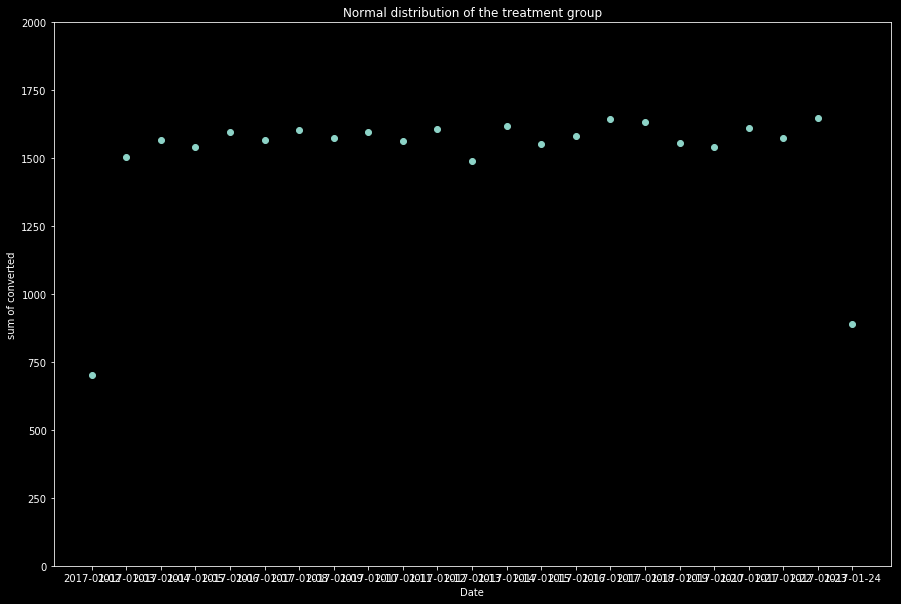

In [78]:
# Plotting
plt.style.use(['dark_background'])
plt.figure(figsize=(15,10))
plt.title('Normal distribution of the treatment group')
plt.xlabel('Date')
plt.ylabel('sum of converted')
plt.ylim(0, 2000)

plt.scatter(df4_plot['date'], df4_plot['converted'])

In [79]:
df4_plot2 = df4.groupby(['date', 'group']).sum()
df4_plot2.reset_index(inplace = True)

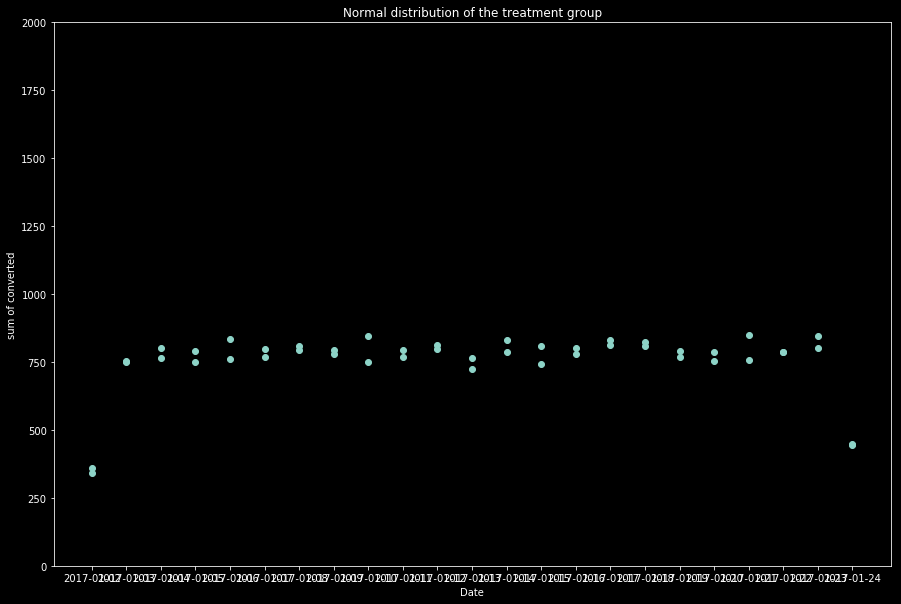

In [80]:
# Plotting
plt.style.use(['dark_background'])
plt.figure(figsize=(15,10))
plt.title('Normal distribution of the treatment group')
plt.xlabel('Date')
plt.ylabel('sum of converted')
plt.ylim(0, 2000)

plt.scatter(df4_plot2['date'], df4_plot2['converted'])

In [81]:
df4.date = df4.date.astype('datetime64[ns]')
start1 = '2017-01-02'
end1 = '2017-01-08'
week1 = pd.date_range(start1, end1)

start2 = '2017-01-09'
end2 = '2017-01-15'
week2 = pd.date_range(start2, end2)

start3 = '2017-01-16'
end3 = '2017-01-22'
week3 = pd.date_range(start3, end3)

start4 = '2017-01-23'
end4 = '2017-01-29'
week4 = pd.date_range(start4, end4)

In [82]:
# Create a list with the week of the A/B test

week_list = []

for i in df4['date']:

    if i in week1:
        week_list.append(1)
    elif i in week2:
        week_list.append(2)
    elif i in week3:
        week_list.append(3)
    else:
        week_list.append(4)


In [83]:
df4['week'] = week_list

In [84]:
# Control the weeks
df4.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,date,week
202015,740834,2017-01-10 07:19:22.576370,treatment,new_page,0,1,1,2017-01-10,2
193502,788908,2017-01-22 13:42:37.592512,treatment,new_page,0,1,1,2017-01-22,3
231263,663849,2017-01-23 16:55:29.261228,treatment,new_page,0,1,1,2017-01-23,4
92975,918612,2017-01-10 09:31:39.443389,treatment,new_page,0,1,1,2017-01-10,2
171214,861135,2017-01-05 06:18:20.196524,treatment,new_page,0,1,1,2017-01-05,1


In [85]:
### Create the necessary dummy variables
pd.get_dummies(df4['week']).head()

,1,2,3,4
0,0,0,1,0
1,0,1,0,0
2,0,1,0,0
3,1,0,0,0
4,0,0,1,0


In [86]:
# Get dummy variables
df4[['week1', 'week2', 'week3', 'week4']] = pd.get_dummies(df4['week'])
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,date,week,week1,week2,week3,week4
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,2017-01-21,3,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,2017-01-12,2,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,2017-01-11,2,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,2017-01-08,1,1,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,2017-01-21,3,0,0,1,0


In [87]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'week2', 'week3', 'week4']])
results4 = log_mod.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            4
Date:                Wed, 06 Mar 2019   Pseudo R-squ.:               2.481e-05
Time:                        11:02:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2599
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9979      0.012   -165.863      0.000      -2.022      -1.974
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
week2          0.0018      0.015      0.120      0.905      -0.027       0.031
week3          0.0195      0.015      1.331      0.183      -0.009       0.048
week4          0.0328      0.024      1.383      0.167      -0.014       0.079
==============================================================================
"""

In [88]:
np.exp(results4.params)

intercept    0.135615
ab_page      0.985152
week2        1.001761
week3        1.019691
week4        1.033314
dtype: float64

The weeks also have just very little impact on the convertion rate